# Machine Learning Basics 2

## Regularization: Ridge Regression Demonstration

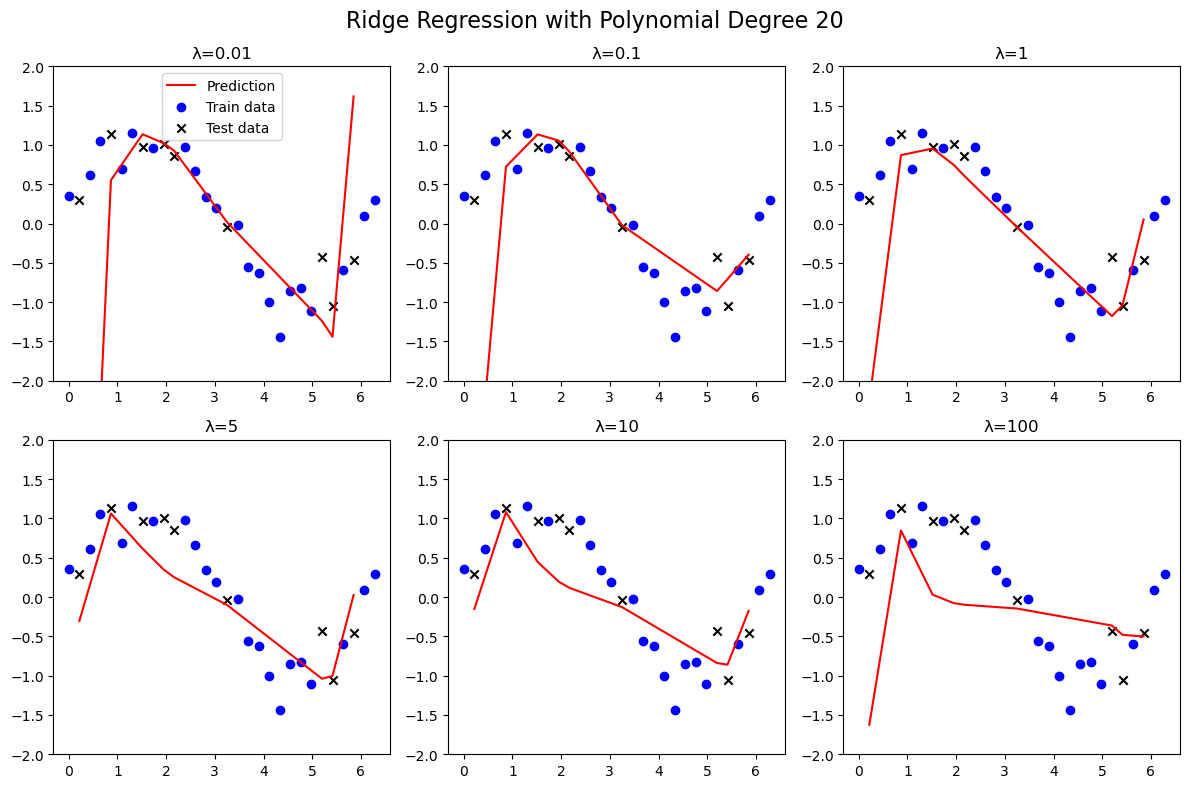

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(0)
X = np.linspace(0, 2 * np.pi, 30)
y = np.sin(X) + 0.2 * np.random.randn(len(X))  # Targeted true function: sin(x) but we add noise

# Train/test split (70% train, 30% test)
indices = np.arange(len(X))
np.random.shuffle(indices)
split = int(0.7 * len(X))
train_idx, test_idx = indices[:split], indices[split:]

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

# Scaling the input features (after scaling -> mean ≈ 0, variance ≈ 1): Improves numeric robustness
def scale(X_tr, X_te):
    mean = X_tr.mean(axis=0)
    std = X_tr.std(axis=0)
    return (X_tr - mean) / std, (X_te - mean) / std

# Polynomial fitting functions
def ridge_regression(X, y, degree, lam):
    X_poly = np.vander(X, degree + 1, increasing=True)
    D = np.eye(degree + 1)
    D[0, 0] = 0  # do not penalize the bias term
    return np.linalg.pinv(X_poly.T @ X_poly + lam * D) @ X_poly.T @ y

def model_prediction(X, coeffs):
    X_poly = np.vander(X, len(coeffs), increasing=True)
    return X_poly @ coeffs

X_train_scaled, X_test_scaled = scale(X_train, X_test)
degree = 20

# Try different lambda values
lambdas = [1e-2, 1e-1, 1, 5, 10, 100]


plt.figure(figsize=(12, 8))
for i, lam in enumerate(lambdas, 1):
    coeffs = ridge_regression(X_train_scaled, y_train, degree, lam)
    y_test_pred = model_prediction(X_test_scaled, coeffs)
    order = np.argsort(X_test)

    plt.subplot(2, 3, i)
    plt.plot(X_test[order], y_test_pred[order], color="r", label="Prediction")
    plt.scatter(X_train, y_train, color="blue", label="Train data")
    plt.scatter(X_test, y_test, color="black", marker="x", label="Test data")
    plt.ylim(-2, 2)
    plt.title(f"λ={lam}")
    if i == 1:
        plt.legend()

plt.suptitle(f"Ridge Regression with Polynomial Degree {degree}", fontsize=16)
plt.tight_layout()
plt.show()


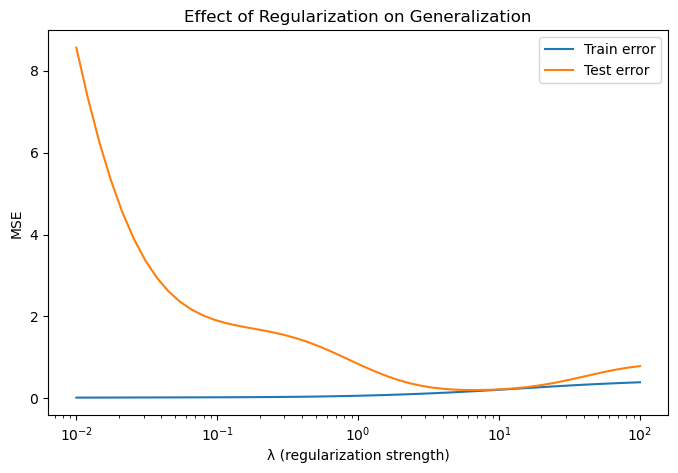

In [2]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

lambda_grid = np.logspace(-2, 2, 50)
train_errors, test_errors = [], []

for lam in lambda_grid:
    coeffs = ridge_regression(X_train_scaled, y_train, degree, lam)
    y_train_pred = model_prediction(X_train_scaled, coeffs)
    y_test_pred = model_prediction(X_test_scaled, coeffs)
    train_errors.append(mse(y_train, y_train_pred))
    test_errors.append(mse(y_test, y_test_pred))

plt.figure(figsize=(8, 5))
plt.semilogx(lambda_grid, train_errors, label="Train error")
plt.semilogx(lambda_grid, test_errors, label="Test error")
plt.xlabel("λ (regularization strength)")
plt.ylabel("MSE")
plt.title("Effect of Regularization on Generalization")
plt.legend()
plt.show()

## Classification with Logistic Regression

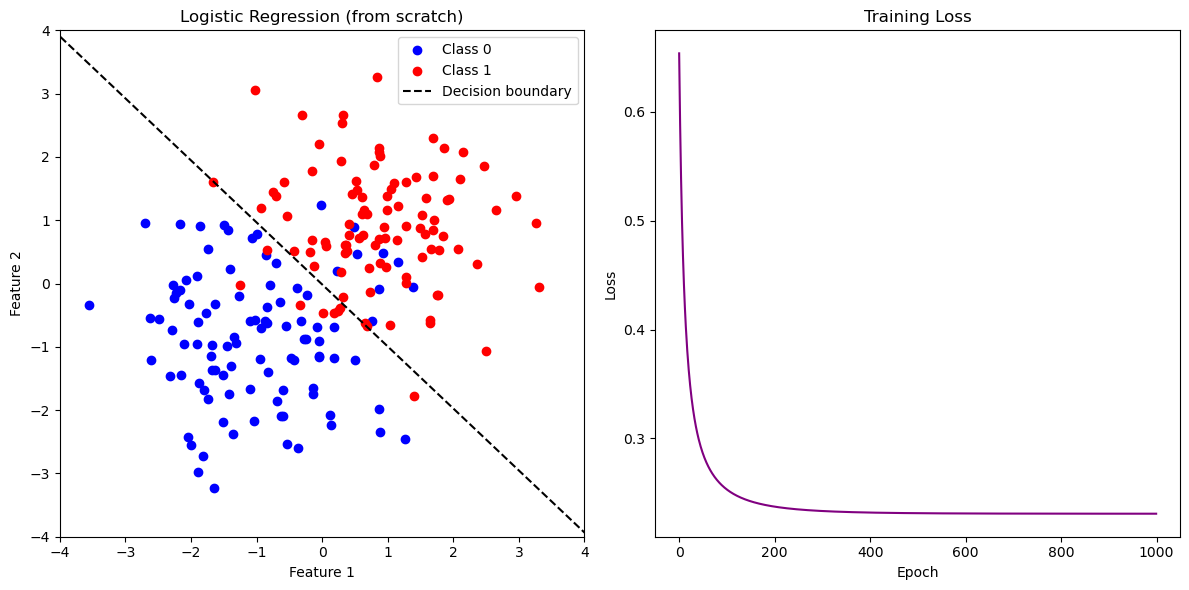

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# Generate toy data (two Gaussian blobs)
N = 100
X_class0 = np.random.randn(N, 2) + np.array([-1, -1])
X_class1 = np.random.randn(N, 2) + np.array([1, 1])

X = np.vstack([X_class0, X_class1])
y = np.array([0]*N + [1]*N)

# Add bias column (intercept term)
X_bias = np.hstack([np.ones((X.shape[0], 1)), X])

# Functions:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict_prob(X, theta):
    return sigmoid(X @ theta)

def predict_class(X, theta):
    return (predict_prob(X, theta) >= 0.5).astype(int)

def loss(X, y, theta):
    h = predict_prob(X, theta)
    return -np.mean(y*np.log(h+1e-12) + (1-y)*np.log(1-h+1e-12))

# Gradient descent
def logistic_regression(X, y, lr=0.1, epochs=1000):
    theta = np.zeros(X.shape[1])
    losses = []
    for _ in range(epochs):
        h = predict_prob(X, theta)
        gradient = X.T @ (h - y) / len(y)
        theta -= lr * gradient
        losses.append(loss(X, y, theta))
    return theta, losses

theta, losses = logistic_regression(X_bias, y, lr=0.1, epochs=1000)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Decision boundary and data
axes[0].scatter(X_class0[:,0], X_class0[:,1], color="blue", label="Class 0")
axes[0].scatter(X_class1[:,0], X_class1[:,1], color="red", label="Class 1")

x1 = np.linspace(-5, 5, 100)
x2 = -(theta[0] + theta[1]*x1) / theta[2]  # line: θ0 + θ1*x1 + θ2*x2 = 0
axes[0].plot(x1, x2, "k--", label="Decision boundary")

axes[0].set_xlim([-4, 4])
axes[0].set_ylim([-4, 4])
axes[0].set_xlabel("Feature 1")
axes[0].set_ylabel("Feature 2")
axes[0].legend(loc="upper right")
axes[0].set_title("Logistic Regression (from scratch)")

# Training loss for gradient descent
axes[1].plot(losses, color="purple")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_title("Training Loss")

plt.tight_layout()
plt.show()


## Under/overfitting with Polynomial Logistic Regression (Classification)

/var/folders/qm/5sjb9c6x42qfnfbqt3vs1x6m0000gn/T/ipykernel_3678/2123153857.py:31: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


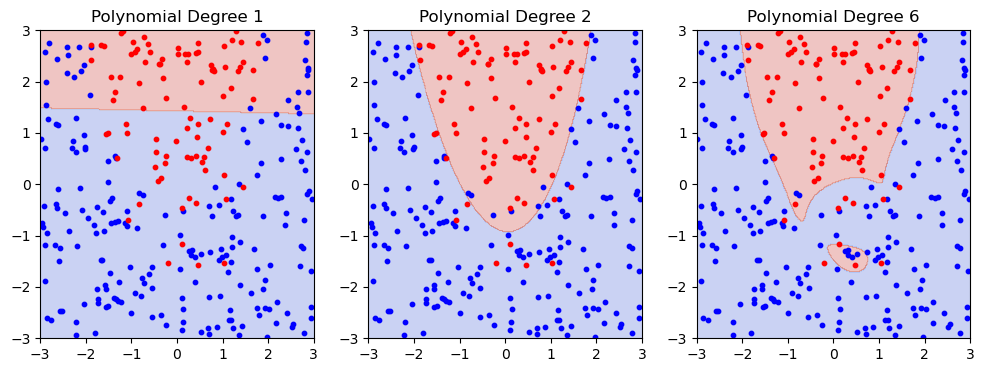

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement

np.random.seed(0)
N = 300
X = np.random.uniform(-3, 3, (N, 2))

# True decision boundary: y = x^2 - 1
y_true = X[:,1] > (X[:,0]**2 - 1)
y = y_true.astype(int)

# Add noise (flip some labels randomly to make non-separable)
dist_to_boundary = np.abs(X[:,1] - (X[:,0]**2 - 1))
flip_prob = 0.5 * np.exp(-dist_to_boundary**2 / 0.5)  # higher prob near boundary
random_vals = np.random.rand(N)
flip_mask = random_vals < flip_prob
y[flip_mask] = 1 - y[flip_mask]

# Functions:
def polynomial_features(X, degree):
    """Return polynomial features up to given degree."""
    n_samples, n_features = X.shape
    features = [np.ones(n_samples)]
    for d in range(1, degree+1):
        for comb in combinations_with_replacement(range(n_features), d):
            features.append(np.prod(X[:, comb], axis=1))
    return np.vstack(features).T

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict_prob(X, theta):
    return sigmoid(X @ theta)

def predict_class(X, theta):
    return (predict_prob(X, theta) >= 0.5).astype(int)

def loss(X, y, theta):
    h = predict_prob(X, theta)
    return -np.mean(y*np.log(h+1e-12) + (1-y)*np.log(1-h+1e-12))

def logistic_regression(X, y, lr=0.1, epochs=1000):
    theta = np.zeros(X.shape[1])
    for _ in range(epochs):
        h = predict_prob(X, theta)
        gradient = X.T @ (h - y) / len(y)
        theta -= lr * gradient
    return theta

# Different degrees of polynomials (higher -> more complex)
degrees = [1, 2, 6]

plt.figure(figsize=(12, 4))
for i, degree in enumerate(degrees, 1):
    X_poly = polynomial_features(X, degree)
    theta = logistic_regression(X_poly, y, lr=0.1, epochs=3000)
    
    # Decision boundary grid
    xx, yy = np.meshgrid(np.linspace(-3, 3, 300), np.linspace(-3, 3, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_poly = polynomial_features(grid, degree)
    Z = predict_class(grid_poly, theta).reshape(xx.shape)
    
    plt.subplot(1, 3, i)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
    plt.scatter(X[y==0,0], X[y==0,1], color="blue", s=10)
    plt.scatter(X[y==1,0], X[y==1,1], color="red", s=10)
    plt.title(f"Polynomial Degree {degree}")
    plt.xlim(-3, 3); plt.ylim(-3, 3)
plt.show()


## K-Means Clustering Demonstration

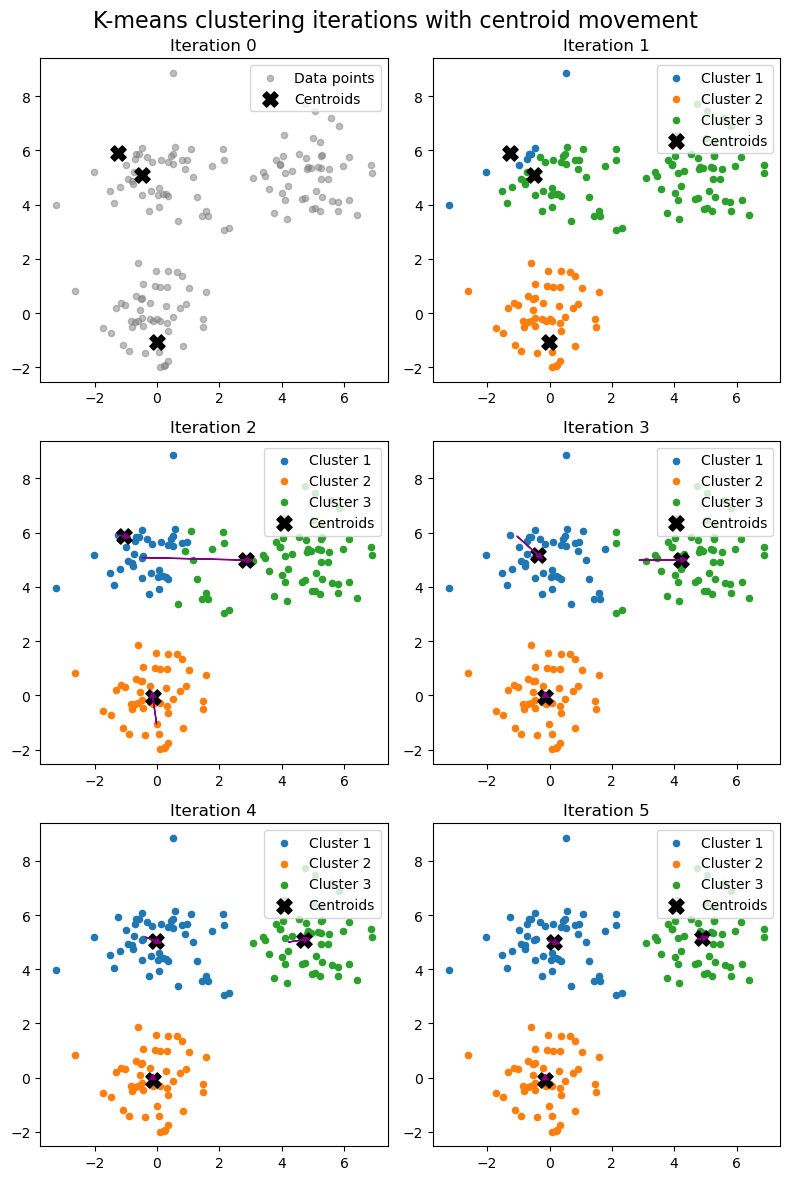

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Three clusters in 2D
np.random.seed(42)
X1 = np.random.randn(50, 2) + np.array([0, 0])
X2 = np.random.randn(50, 2) + np.array([5, 5])
X3 = np.random.randn(50, 2) + np.array([0, 5])
X = np.vstack([X1, X2, X3])

def kmeans(X, K=3, max_iters=6):
    rng = np.random.default_rng(17)
    centroids = X[rng.choice(len(X), K, replace=False)]  # Random initialization of centroids
    history = [(centroids.copy(), None)]  # Iteration 0 (no labels yet)

    for _ in range(max_iters):
        # Step 1: Assign points to nearest centroid
        distances = np.linalg.norm(X[:, None] - centroids[None, :], axis=2)
        labels = np.argmin(distances, axis=1)

        # Save state for plotting
        history.append((centroids.copy(), labels.copy()))

        # Step 2: Update centroids
        new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(K)])
        if np.allclose(centroids, new_centroids, rtol=1e-3):
            break
        centroids = new_centroids

    # Compute inertia (sum of squared distances to nearest centroid)
    inertia = np.sum((X - centroids[labels])**2)

    return centroids, labels, history, inertia

final_centroids, final_labels, history, _ = kmeans(X, K=3, max_iters=10)

# --- Plot iterations (max 2 per row) ---
n_iter = len(history)
n_cols = 2
n_rows = int(np.ceil(n_iter / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 4*n_rows))
axes = axes.flatten()

for i, (centroids, labels) in enumerate(history):
    ax = axes[i]

    # Plot points
    if labels is None:  # Iteration 0
        ax.scatter(X[:, 0], X[:, 1], c="gray", s=20, alpha=0.5, label="Data points")
    else:
        for k in range(3):
            ax.scatter(X[labels == k, 0], X[labels == k, 1], s=20, label=f"Cluster {k+1}")

    # Plot centroids
    ax.scatter(centroids[:, 0], centroids[:, 1], c="black", s=120, marker="X", label="Centroids")

    # Draw arrows showing centroid movement (skip Iteration 1)
    if i > 1:
        prev_centroids, _ = history[i-1]
        for (x_old, y_old), (x_new, y_new) in zip(prev_centroids, centroids):
            ax.arrow(x_old, y_old,
                     x_new - x_old, y_new - y_old,
                     head_width=0.2, head_length=0.2, fc="purple", ec="purple")

    ax.set_title(f"Iteration {i}")
    ax.legend(loc="upper right")

# Hide unused subplots if any
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.suptitle("K-means clustering iterations with centroid movement", fontsize=16)
plt.tight_layout()
plt.show()


### Exercise 6.1

Plot inertia vs. number of clusters K

You get the intertia with the above function, for example for K=5:

`_, _, _, inertia = kmeans(X, K=5, max_iters=20`)`

In [6]:
# Your code below:

## Principle Component Analysis (PCA) Demonstration

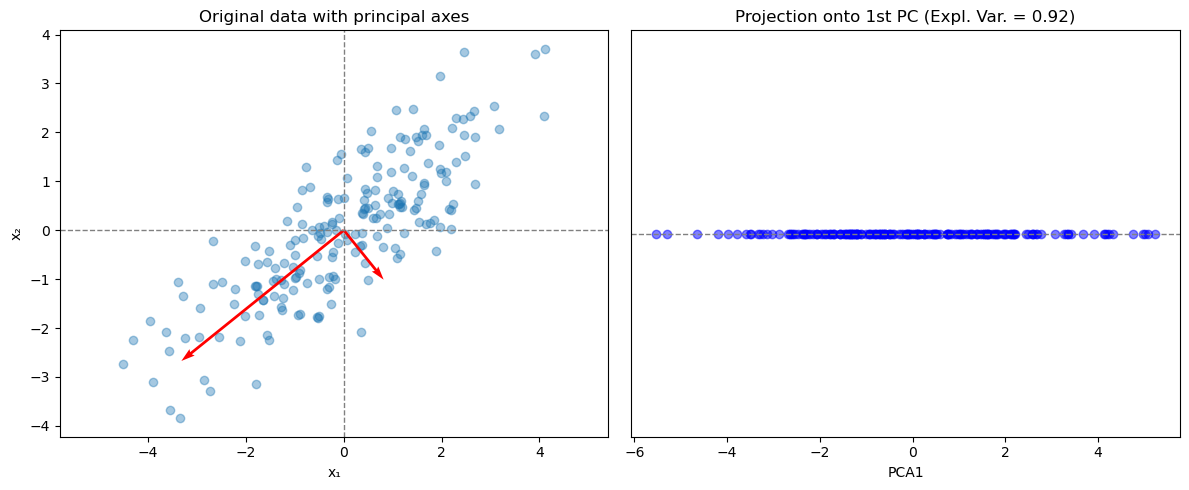

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Correlated data in 2D:
np.random.seed(0)
mean = [0, 0]
cov = [[3, 2], [2, 2]]  # correlated features
X = np.random.multivariate_normal(mean, cov, size=200)

# Step 1: Center the data
X_centered = X - X.mean(axis=0)

# Step 2: Compute covariance matrix
cov_matrix = np.cov(X_centered, rowvar=False)

# Step 3: Eigen decomposition
eigvals, eigvecs = np.linalg.eigh(cov_matrix)  # symmetric
order = np.argsort(eigvals)[::-1]
eigvals, eigvecs = eigvals[order], eigvecs[:, order]

# Step 4: Project data into PCA coordinates
X_pca = X_centered @ eigvecs

# Explained variance ratio:
explained_var_ratio = eigvals / eigvals.sum()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_centered[:, 0], X_centered[:, 1], alpha=0.4)
origin = np.mean(X_centered, axis=0)
for val, vec in zip(eigvals, eigvecs.T):
    plt.quiver(*origin, *(vec * np.sqrt(val) * 2),
               angles='xy', scale_units='xy', scale=1, color='red', width=0.005)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Original data with principal axes")
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.axis("equal")

# Plotting projection onto first principle axis
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], np.zeros_like(X_pca[:, 0]), alpha=0.5, c="blue")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title(f"Projection onto 1st PC (Expl. Var. = {explained_var_ratio[0]:.2f})")
plt.xlabel("PCA1")
plt.yticks([])  # hide y-axis since it's 1D

plt.tight_layout()
plt.show()
